# DSCI 100 Project: Final report
<u><b>Group 4 from DSCI 100 008</b></u>
<br>
Minh Anh
<br>
Angel Chen (71703029)
<br>
Angelica Pen
<br>
Anjiu Shi

In [1]:
# Please run this cell first.
library(repr)
library(tidyverse)
library(tidymodels)
library(themis)
library(gridExtra)
options(scipen = 999, repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## <u>Introduction</u>
### <u>Background</u>
Our report uses the data collected by the Pacific Laboratory for Artificial Intelligence (PLAI), a Computer Science research group at UBC led by Dr. Frank Wood. This research group has set up their own Minecraft server, accessible through the PLAICraft.ai browser, in which players can can communicate with each other through a built-in voice-chat. They record the actions and speech of players to train AGI-like agents to potentially create more human-like NPCs in games in the future.

We are helping them with their project by investigating what kinds of players are more likely to contribute more data, so they know where to focus their recruitment efforts (***General Question 2***).

### <u>Developing our research question</u>
Can we predict a player's data contribution (i.e. hours of Minecraft played on PLAICraft.ai) using a selection of the player's characteristics (experience level, subscription status, gender, or age)? Our method (see Methods and results) has helped us further refine this question to form our specific research question:

#### Can we predict a player's data contribution (`played_hours`) using the player's Minecraft experience level (`experience`) and subscription status to game-related newsletter (`subscribe`) from the dataset `players.csv`?
We'll explain how we arrived at this question. First, let's load the `players.csv` dataset, which we'll use for our analysis.

In [28]:
# Loading players.csv and sessions.csv and tidying them. We will only be using players.csv for analysis,
# but sessions.csv is included for us to explain our method later.

# players.csv
og_players <- read_csv("https://raw.githubusercontent.com/achen45-png/toy_ds_project/refs/heads/main/data/players.csv",
                       show_col_types = FALSE)

players <- og_players |>
    mutate(
        experience = as_factor(experience), # Correcting the data types.
        gender = as_factor(gender),
        Age = as.integer(Age),
        subscribe = as_factor(subscribe) # Logical is indeed the most appropriate data type, but I'm changing it to
    )                                    # factor because step_dummy() in a later step only works with factors.

# Code that yielded Table 2, summary statistics of players.csv.
players_summary <- players |>
    summarize(
        min_played_hours = min(played_hours, na.rm = TRUE),
        max_played_hours = max(played_hours, na.rm = TRUE),
        mean_played_hours = mean(played_hours, na.rm = TRUE),
        median_played_hours = median(played_hours, na.rm = TRUE),
        min_age = min(Age, na.rm = TRUE),
        max_age = max(Age, na.rm = TRUE),
        mean_age = mean(Age, na.rm = TRUE),
        median_age = median(Age, na.rm = TRUE),
    )

# sessions.csv
sessions <- read_csv("https://raw.githubusercontent.com/achen45-png/toy_ds_project/refs/heads/main/data/sessions.csv",
                     show_col_types = FALSE) |>
    mutate(
        start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M", tz = "GMT"),
        end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M", tz = "GMT")    
    ) |>
    na.omit()
# Changing the date and times from character to datetime data in sessions.csv is kind of unnecessary given that
# we are not using this dataset for our analysis. However, I included it anyway because I want to show a point.

### <u>Data description</u>

The `players.csv` dataset is loaded as `og_players`, then tidied as `players`.

In [3]:
og_players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


`experience` and `gender` are categorical variables with a limited selection of values, so factor is better suited than character. Age is usually represented as a positive integer, so `Age` is changed to integer. `subscribe` is appropriately represented as a logical variable, but we changed it to factor to ease our analysis later.

In [4]:
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


`players` data comprises 7 variables (Table 1) and 196 observations.

|Variable|Data type|Explanation|
|--------|--------|--------|
|`experience`|~~character~~ factor|Participant's self-identified Minecraft experience level<br>(options include Beginner, Amateur, Regular, Veteran, Pro)|
|`subscribe`|~~logical~~ factor|Participant's subscription to game-related newsletter<br>(`TRUE` if subscribed, `FALSE` otherwise)|
|`hashedEmail`|character|64-digit hash encoding participant's email, a unique combination<br>of numbers and letters for each participant|
|`played_hours`|double|Total hours of Minecraft played on the PLAICraft.ai browser|
|`name`|character|Player's submitted name|
|`gender`|~~character~~ factor|Player's self-identified gender (options include Male, Female,<br>Non-binary, Agender, Two-Spirited, Other, and Prefer not to say)|
|`Age`|~~double~~ integer|Player's submitted age|

<center><b><i>Table 1</i></b> Variables of <code>players</code>. Strikethroughs represent data types from <code>players.csv</code> that were changed in <code>players</code> data for tidying.</center>
<br>
<br>

|Variable|Minimum|Maximum|Median|Mean|
|--------|--------|--------|--------|--------|
|`played_hours`|0|223.1|0.1|5.85|
|`Age`|9|58|19|21.14|

<center><b><i>Table 2</i></b> Summary of <code>players</code> quantitative variables.</center>
<br>

Each observation in `players.csv` represents a unique participant who has *registered* to play Minecraft on PLAICraft.ai, not who has actually played. There are 196 registered players, half of which have `played_hours` less than 0.1 hours (Table 2). The variables are summarized in Table 1. `played_hours` will serve as our indicator for data contribution. We assume that players who play more on PLAICraft.ai contribute more data. As this dataset captures personal characteristics (`experience`, `gender`, `age`), we can train a predictive model to capture the characteristics of players who contribute the most (or the least) data and predict the potential data contribution of new players. We're also interested in including `subscribe` as a potential predictor. However, `experience`, `gender`, and `age` are self-reported. We use this data under the assumption that the reported values are true. Furthermore, since `experience` is not standardized by researchers, it may be more appropriate to call it "a player's self-confidence in Minecraft experience".

We will not be using `sessions.csv` because it is not a good metric for player data contribution.

hashedEmail,num_sessions
<chr>,<int>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159
⋮,⋮
fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,1
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1


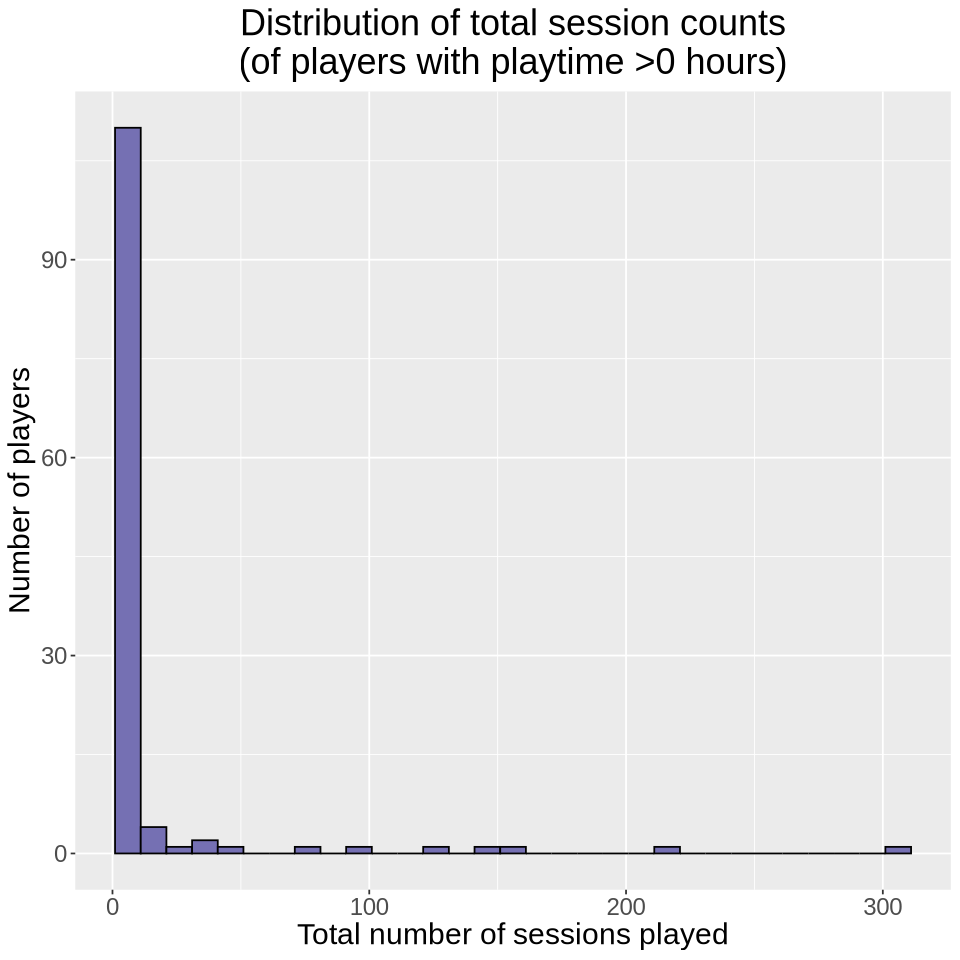

In [5]:
sessions_unique_hash <- sessions |>
    group_by(hashedEmail) |>
    summarize(num_sessions = n()) |>
    arrange(desc(num_sessions))
sessions_unique_hash

options(repr.plot.width = 8, repr.plot.height = 8)
sessions_count <- sessions_unique_hash |>
    ggplot(aes(num_sessions)) +
        geom_histogram(colour = "black", fill = "#7570b3ff", binwidth = 10, boundary = 1) +
        labs(x = "Total number of sessions played", y = "Number of players",
             title = "Distribution of total session counts\n(of players with playtime >0 hours)") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5))
sessions_count

***Graph 1*** Derived from `sessions.csv` by counting each unique `hashedEmail`'s number of observations in the dataset. One observation marks one gaming session, i.e. one instance of a player’s uninterrupted Minecraft session on PLAICraft.ai, so we can count how many sessions each player has played (for players with more than 0 hours of playtime). This graph shows a distribution of the total counts of players' sessions.

<br>

As we can see, one may argue from the distribution of total session counts that players who logged in more often played the game more and therefore have higher data contribution. However, the average duration of each player's sessions vary. Some play for 67 minutes per session on average, while others only play for 15 minutes (see code below, `mean_sesh_duration` vs. `num_sessions`
). Therefore, session count is not a good metric for player data contribution. `played_hours` from `players.csv` is sufficient to study players' data contribution.

In [6]:
sessions_duration <- sessions |>
    mutate(time_diff = end_time - start_time) |>
    group_by(hashedEmail) |>
    summarize(mean_sesh_duration = mean(time_diff),
              median_sesh_duration = median(time_diff)) |>
    merge(sessions_unique_hash) |>
    arrange(desc(num_sessions))
head(sessions_duration, n = 6)
tail(sessions_duration, n = 6)

,hashedEmail,mean_sesh_duration,median_sesh_duration,num_sessions
,<chr>,<drtn>,<drtn>,<int>
1,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15.46774 mins,7 mins,310
2,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,66.99087 mins,63 mins,219
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,62.55975 mins,49 mins,159
4,ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,80.45578 mins,62 mins,147
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,29.79231 mins,22 mins,130
6,b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,150.34043 mins,143 mins,94


,hashedEmail,mean_sesh_duration,median_sesh_duration,num_sessions
,<chr>,<drtn>,<drtn>,<int>
120,f707d141be44b2bf963eb171dbd14599059b4dda09aa002ba95ead4fa67273a7,8 mins,8 mins,1
121,f7875ae87a61632030d5c4029ee8cf081be7047b2b4a9c04ab5a706f59786197,19 mins,19 mins,1
122,fc0224c81384770e93ca717f32713960144bf0b52ff67639433a5c06a653a882,16 mins,16 mins,1
123,fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,80 mins,80 mins,1
124,fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,9 mins,9 mins,1
125,fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,72 mins,72 mins,1


## <u>Exploratory data analysis (no additional wrangling)</u>

Exploring the relationship between variables:
By creating a pairplot (scatterplot matrix) of all the columns/predictors we're interested in, we evaluate the graphs involving the variable played_hours. The graphs indicate a non-linear relationship between all potential predictors and our response variable played_hours, hence we use that as a sign to use KNN regression instead of linear regression.

ALSO: WE HAVE CATEGORICAL VARIABLES, WHICH CANNOT HAVE LINEAR RELATIONSHIP WITH ANYTHING

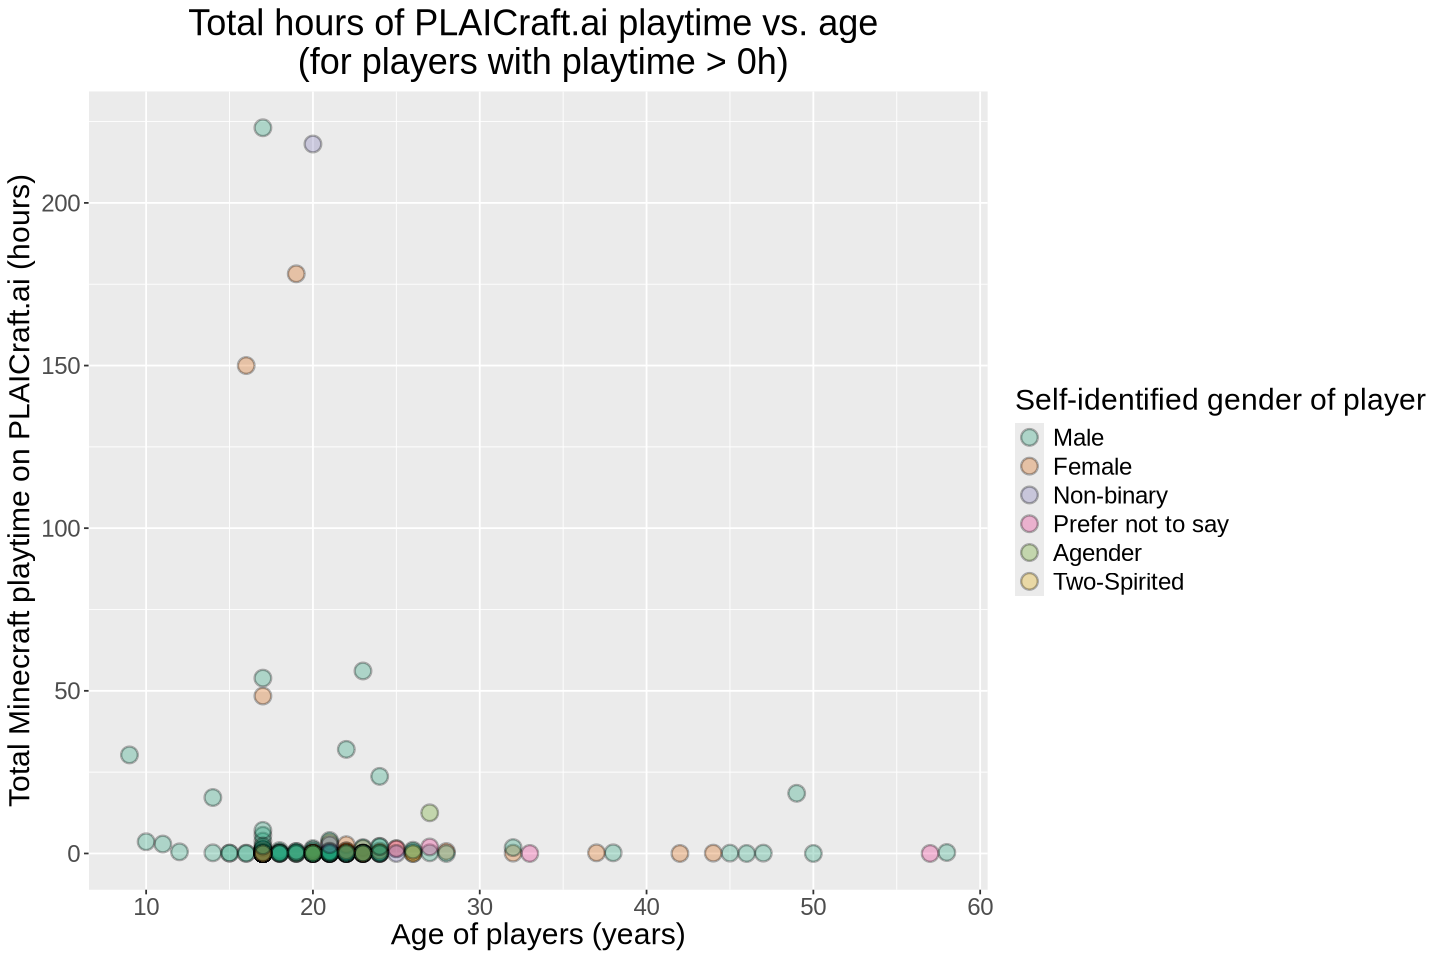

In [7]:
options(repr.plot.width = 12, repr.plot.height = 8)
hour_v_age <- players |>
    na.omit() |> # Removing 2 NA's (2 observations).
    ggplot(aes(x = Age, y = played_hours, fill = gender)) +
        geom_point(alpha = 0.3, size = 4, stroke = 1, shape = 21) +
        labs(x = "Age of players (years)", y = "Total Minecraft playtime on PLAICraft.ai (hours)", fill = "Self-identified gender of player",
             title = "Total hours of PLAICraft.ai playtime vs. age \n (for players with playtime > 0h)") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_fill_brewer(palette = "Dark2") +
        scale_colour_brewer(palette = "Dark2")
hour_v_age

***Graph 2*** From `players` data, `played_hours` vs. `Age`, coloured by `gender`. Only participants with `played_hours` > 0 hours are included.

## <u>Methods and results</u>

Initially, we asked if we could predict a player's data contribution (`played_hours`) using a ***selection*** of the player's characteristics (`experience`, `subscribe`, `gender`, `Age`). To refine our research question, we used **best subset selection** to compute the most suitable combination of the player's characteristics as predictor variables for our response variable `played_hours`. Not every player characteristic may be suitable for predicting the number of played hours.

We decided to use K-nearest neighbours (KNN) regression for our predictive analysis. Three of our potential predictor variables (`experience`, `subscribe`, and `gender`) are categorical variables. The remaining `Age` does not appear to have a linear relationship with `played_hours` (Graph 2). We are using non-linear predictive variables to estimate a numerical response variable, making KNN regression the optimal preditive algorithm.

We first removed the columns we don't need (`hashedEmail`, `name`) in `players` and omitted observations with `NA`. Then, we split `players` data into 75% training and 25% testing.

In [8]:
set.seed(42) # NOBODY TOUCH THIS PLEASE.

# I decided to use best subset selection over forward selection because we don't have that many potential predictor variables
# anyway (only 4). Since we don't have any computational costs or limits for using best subset selection, there's no reason not to,
# especially when forward selection is not as comprehensive.

# For convenience, columns we don't need for analysis are removed.
players_removed <- players |>
    select(-hashedEmail, -name) |>
    na.omit()

# Splitting the data.
players_split <- initial_split(players_removed, prop = 0.75, strata = played_hours) # Standard 75/25 split for training/testing.
players_training <- training(players_split)
players_testing <- testing(players_split)

### <u>Pre-processing</u>
Next, using the training data, we performed 10-fold cross-validation on all 15 candidate models made from the 15 possible combinations (subsets) of predictor variables. To make the categorical predictor variables (`experience`, `subscribe`, `gender`) usable in the KNN regression model, we converted them into dummy variables using the pre-processing steps in our `tidymodels` recipe (`step_dummy()`). As KNN regression uses numerical straight-line distances to make predictions, it cannot directly handle text-based categories. `subscribe` was converted from logical to factor (Table 1) for this very purpose, as `step_dummy()` can only process factors. Unlike `subscribe` and `gender`, `experience` is an ordinal categorical variable. However, we decided against converting it to numbers like 1 to 5 because doing so assumes that the difference between each category (e.g. beginner vs. amateur, amateur vs. regular) is the same.

We used a grid of numbers of neighbours $K$ ranging from 1 to 10, tuned all 15 candidate models, and returned for each model (1) the lowest RMSPE and (2) the $K$ that gave the lowest RMSPE.

In [9]:
# knn tuning model that will be used for every candidate model.
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

In [10]:
# A separate code cell for all the recipes.
# Recipes for each possible combination of predictor variables (15 total). Our response variable is played_hours.

# 1 predictor
# Recipe 1: experience
recipe_1 <- recipe(played_hours ~ experience, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |> # Scale and center are not necessary when there's only 1 predictor.
    step_center(all_predictors())   # They're there because I copy-pasted the recipes. :D
# Recipe 2: subscribe
recipe_2 <- recipe(played_hours ~ subscribe, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 3: gender
recipe_3 <- recipe(played_hours ~ gender, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 4: Age
recipe_4 <- recipe(played_hours ~ Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 2 predictors
# Recipe 5: experience + subscribe
recipe_5 <- recipe(played_hours ~ experience + subscribe, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 6: experience + gender
recipe_6 <- recipe(played_hours ~ experience + gender, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 7: experience + Age
recipe_7 <- recipe(played_hours ~ experience + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 8: subscribe + gender
recipe_8 <- recipe(played_hours ~ subscribe + gender, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 9: subscribe + Age
recipe_9 <- recipe(played_hours ~ subscribe + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 10: gender + Age
recipe_10 <- recipe(played_hours ~ gender + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 3 predictors
# Recipe 11: experience + subscribe + gender
recipe_11 <- recipe(played_hours ~ experience + subscribe + gender, data = players_training) |>
     step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 12: experience + subscribe + Age
recipe_12 <- recipe(played_hours ~ experience + subscribe + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 13: experience + gender + Age
recipe_13 <- recipe(played_hours ~ experience + gender + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 14: subscribe + gender + Age
recipe_14 <- recipe(played_hours ~ subscribe + gender + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 4 predictors
# Recipe 15: ALL 4 variables, experience + subscribe + gender + Age
recipe_15 <- recipe(played_hours ~ ., data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# I tried to make a recipe_printer, but it was impossible so we're stuck with this tedious code. :(

In [11]:
set.seed(84) # NOBODY TOUCH THIS PLEASE.

# Running 10-fold cross-validation for all candidate models.
vfold <- vfold_cv(players_training, v = 10, strata = played_hours)

# Range of k values.
kvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# A convenient function that spits out the best k and lowest rmspe (mean) of any candidate model (recipe).
workflow_printer <- function(recipe, model) {
    workflow() |>
    add_recipe(recipe) |>
    add_model(model) |>
    tune_grid(resamples = vfold, grid = kvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)
}

workflow_1 <- workflow_printer(recipe_1, knn_tune)
workflow_2 <- workflow_printer(recipe_2, knn_tune)
workflow_3 <- workflow_printer(recipe_3, knn_tune)
workflow_4 <- workflow_printer(recipe_4, knn_tune)
workflow_5 <- workflow_printer(recipe_5, knn_tune)
workflow_6 <- workflow_printer(recipe_6, knn_tune)
workflow_7 <- workflow_printer(recipe_7, knn_tune)
workflow_8 <- workflow_printer(recipe_8, knn_tune)
workflow_9 <- workflow_printer(recipe_9, knn_tune)
workflow_10 <- workflow_printer(recipe_10, knn_tune)
workflow_11 <- workflow_printer(recipe_11, knn_tune)
workflow_12 <- workflow_printer(recipe_12, knn_tune)
workflow_13 <- workflow_printer(recipe_13, knn_tune)
workflow_14 <- workflow_printer(recipe_14, knn_tune)
workflow_15 <- workflow_printer(recipe_15, knn_tune)

# Combining each candidate model's best k and lowest rmspe for comparison.
best_subset <- rbind(workflow_1, workflow_2, workflow_3, workflow_4, workflow_5,
                     workflow_6, workflow_7, workflow_8, workflow_9, workflow_10,
                     workflow_11, workflow_12, workflow_13, workflow_14, workflow_15) |>
    mutate(recipe_workflow_n = c(1:15)) |>
    arrange(mean)

→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x1



→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x6

There were issues with some computations   A: x10



→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x2

There were issues with some computations   A: x2



→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a 

We compared the lowest RMSPE values from each of the 15 candidate models and chose the model with the lowest overall RMSPE.

In [12]:
head(best_subset, n = 6)

neighbors,.metric,.estimator,mean,n,std_err,.config,recipe_workflow_n
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<int>
10,rmse,standard,23.46515,10,7.282559,Preprocessor1_Model10,5
1,rmse,standard,23.91264,10,7.579489,Preprocessor1_Model01,2
1,rmse,standard,23.91396,10,7.581235,Preprocessor1_Model01,3
1,rmse,standard,23.91665,10,7.579021,Preprocessor1_Model01,1
1,rmse,standard,23.92039,10,7.581346,Preprocessor1_Model01,8
10,rmse,standard,25.09563,10,7.120350,Preprocessor1_Model10,9


From our pre-processing 10-fold cross-validation with the 15 candidate models, we see that the model using `experience` and `subscribe` (`recipe_5` / `workflow_5`) with $K$ = 10 has the lowest RMSPE overall (23.47) compared to the lowest RMSPE of each individual candidate model. From this, we derived our **specific research question** stated in the beginning:
#### Can we predict a player's data contribution (`played_hours`) using the player's Minecraft experience level (`experience`) and subscription status to game-related newsletter (`subscribe`) from the dataset `players.csv`?

### <u>Evaluating on the testing data</u>
Now, we evaluated our finalized KNN regression model on the testing set. We first re-trained our model on the entire training set.

In [25]:
# Building the "official" knn regression model using recipe 5 and k = 10.
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
    set_engine("kknn") |>
    set_mode("regression")

# Training the model using the entirety of the training set.
players_knn_fit <- workflow() |>
    add_recipe(recipe_5) |>
    add_model(knn_spec_final) |>
    fit(data = players_training)

Unfortunately, we cannot visualize our predictions because (1) we have 2 predictors, so we would need a 3D space to visualize them against the response variable and (2) the predictor variables are categorical. We cannot assess if our model is over- or underfitting the training data.

Let's move on to use the fully trained model to predict `played_hours` in the testing set.

In [27]:
# Using the fully trained model on the testing set.
players_pred <- players_knn_fit |>
    predict(players_testing) |>
    bind_cols(players_testing)
players_pred

# Extracting the RMSPE from using our model on the testing set.
players_knn_rmspe <- players_pred |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == "rmse")
players_knn_rmspe

.pred,experience,subscribe,played_hours,gender,Age
<dbl>,<fct>,<fct>,<dbl>,<fct>,<int>
0.72,Veteran,FALSE,0.0,Male,17
0.03,Amateur,TRUE,0.7,Female,21
0.03,Veteran,TRUE,0.0,Female,22
⋮,⋮,⋮,⋮,⋮,⋮
0.31,Pro,FALSE,0.2,Male,17
0.46,Amateur,FALSE,0.0,Male,17
0.72,Veteran,FALSE,0.3,Male,22


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,12.22768


## <u>Discussion</u>

Our final model's RMSPE from the testing set is 12.23, which is a significant improvement from 23.47, the RMSPE of our tuned model. However, this large difference in RMSPE can indicate that our model's prediction ability is inconsistent. With how the data was randomly assigned to the training set or the validation/testing set, the data assigned to the final testing set could've just been really "lucky", allowing our model to fit the data really well by chance.

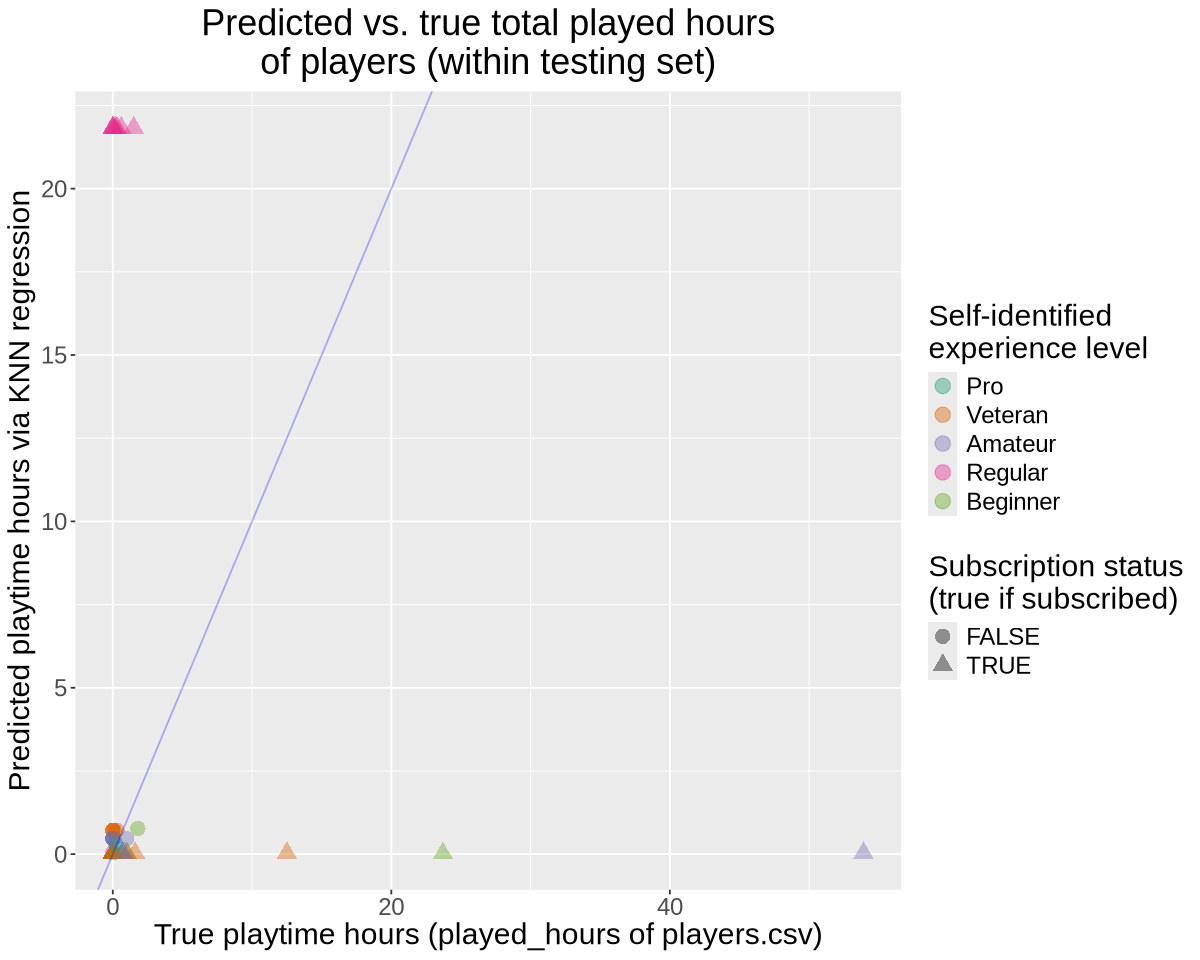

In [21]:
options(repr.plot.width = 10, repr.plot.height = 8)
pred_vs_true <- players_pred |>
    ggplot(aes(x = played_hours, y = .pred, colour = experience, shape = subscribe)) +
        geom_point(alpha = 0.4, size = 4) +
        labs(x = "True playtime hours (played_hours of players.csv)", y = "Predicted playtime hours via KNN regression",
             title = "Predicted vs. true total played hours\nof players (within testing set)", colour = "Self-identified\nexperience level",
             shape = "Subscription status\n(true if subscribed)") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_colour_brewer(palette = "Dark2") +
        geom_abline(slope = 1, intercept = 0, colour = "blue", alpha = 0.3)
pred_vs_true

***Graph 3???*** From `players_pred`, the prediction results of our finalized KNN regression model on the testing set (25% of `players.csv`). Predicted `played_hours` is plotted against actual `played_hours`, with experience level indicated by colour and subscription status indicated by shape. **The blue line is not the best-fit line**; it is $y = x$. Any prediction value that equals the actual value would fall on this line.

Our model is deceptively accurate (low RMSPE) because most players within `players.csv` have very low playtimes (median playtime is 0.1 hours, see Table 2). As we can see in Graph 3(**???**), there is a player with over 50 hours of true playtime predicted by the model to have around 0 hours. On the other hand, there are multiple players with around 0 hours of true playtime predicted to have over 20 hours. Incidentally, all of these players have Regular experience level.

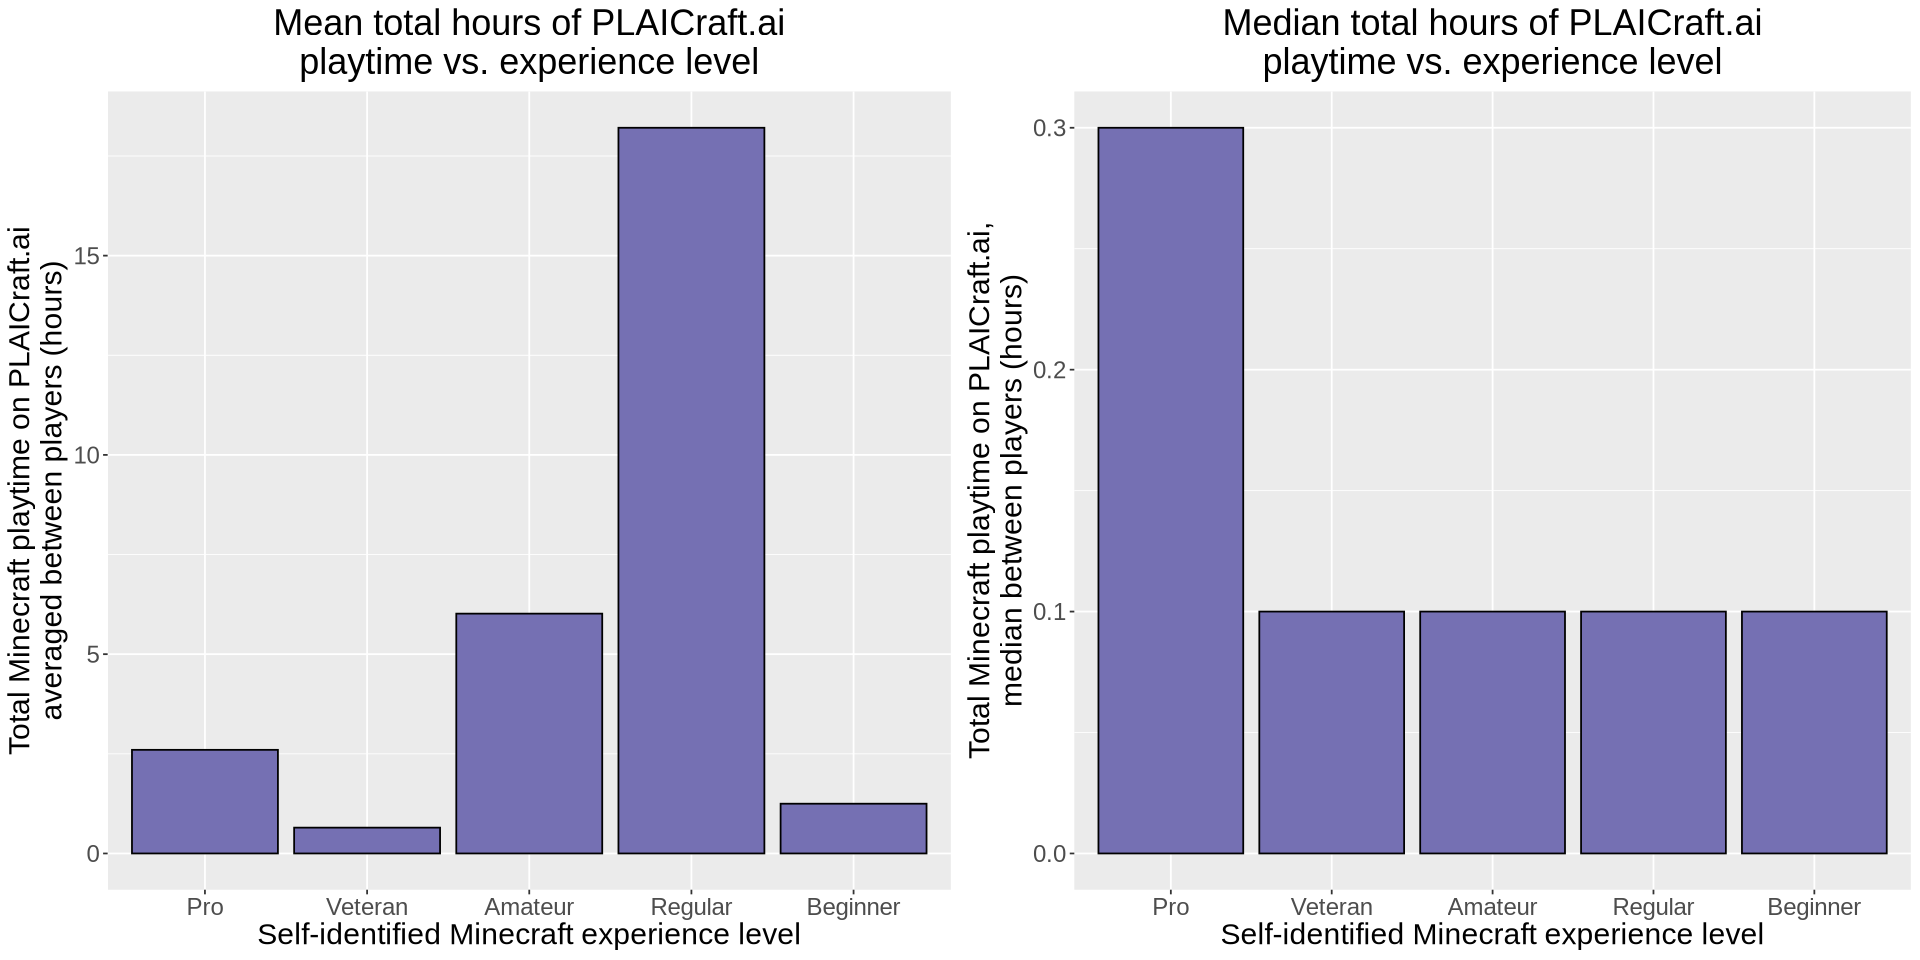

In [15]:
hour_v_exp_mean <- players |>
    group_by(experience) |>
    summarize(played_hours = mean(played_hours)) |>
    ggplot(aes(x = experience, y = played_hours)) +
        geom_bar(stat = "identity", colour = "black", fill = "#7570b3ff") +
        labs(x = "Self-identified Minecraft experience level",
             y = "Total Minecraft playtime on PLAICraft.ai\naveraged between players (hours)",
             title = "Mean total hours of PLAICraft.ai\nplaytime vs. experience level") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_colour_brewer(palette = "Dark2")

hour_v_exp_med <- players |>
    group_by(experience) |>
    summarize(played_hours = median(played_hours)) |>
    ggplot(aes(x = experience, y = played_hours)) +
        geom_bar(stat = "identity", colour = "black", fill = "#7570b3ff") +
        labs(x = "Self-identified Minecraft experience level",
             y = "Total Minecraft playtime on PLAICraft.ai,\nmedian between players (hours)",
             title = "Median total hours of PLAICraft.ai\nplaytime vs. experience level") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_colour_brewer(palette = "Dark2")

options(repr.plot.width = 16, repr.plot.height = 8)
grid.arrange(hour_v_exp_mean, hour_v_exp_med, ncol = 2)

***Graph 4???*** From `players.csv`, side-by-side comparison of the mean and median `played_hours` of all players, categorized by experience level.

We see that the high average playtime for players with Regular experience is skewed by a few players, as the median is only 0.1 hours (Graph 4). It is very likely that our training set included all the Regular players with high `played_hours`, so when the model was used on the testing set, it incorrectly predicted all players with Regular experience to have higher `played_hours` (Graph 3).